In [1]:
import pandas as pd
import os
import os.path as op
import glob
import re
import nibabel as nib
import numpy as np

from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
import gzip
import pickle

In [2]:
def dice_coefficient(mask1, mask2):
    """
    Calculate Dice similarity coefficient between two binary masks.
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    
    Parameters:
    -----------
    mask1, mask2 : array-like or nibabel image
        Binary masks (3D arrays or nibabel images)
    
    Returns:
    --------
    dice : float
        Dice coefficient (0-1, where 1 = perfect overlap)
    """
    # Convert to arrays if nibabel images
    if hasattr(mask1, 'get_fdata'):
        mask1 = mask1.get_fdata()
    if hasattr(mask2, 'get_fdata'):
        mask2 = mask2.get_fdata()
    
    # Flatten and binarize
    mask1_flat = (mask1.flatten() > 0).astype(int)
    mask2_flat = (mask2.flatten() > 0).astype(int)
    
    # Calculate intersection and sizes
    intersection = np.sum(mask1_flat * mask2_flat)
    size1 = np.sum(mask1_flat)
    size2 = np.sum(mask2_flat)
    
    # Avoid division by zero
    if size1 + size2 == 0:
        return 0.0
    
    dice = (2.0 * intersection) / (size1 + size2)
    return dice

In [3]:
def pairwise_dice_scores(roi_files, output_dir=None, force_recalc=False):
    """
    Calculate pairwise Dice coefficients between all subject-specific ROIs.
    Saves results to disk to avoid recomputation.
    
    Parameters:
    -----------
    roi_files : list
        List of file paths to subject-specific ROI NIfTI files
    output_dir : str, optional
        Directory to save/load results. If None, uses directory of first ROI file.
    force_recalc : bool, optional
        If True, recalculate even if saved files exist. Default: False
    
    Returns:
    --------
    dice_matrix : numpy.ndarray
        Symmetric matrix where dice_matrix[i,j] is the Dice coefficient 
        between ROI i and ROI j
    roi_names : list
        List of ROI filenames for indexing the matrix
    pairwise_dice_values : numpy.ndarray
        1D array of unique pairwise Dice values (excluding diagonal)
    
    Notes:
    ------
    Pickle file structure (dict):
        {
            'dice_matrix': numpy.ndarray,
            'roi_names': list,
            'pairwise_dice_values': numpy.ndarray
        }
    
    Load with: import gzip, pickle
               with gzip.open('results.pkl.gz', 'rb') as f:
                   data = pickle.load(f)
               dice_matrix = data['dice_matrix']
               roi_names = data['roi_names']
               pairwise_values = data['pairwise_dice_values']
    """
    import pickle
    import gzip
    
    # Set output directory
    if output_dir is None:
        output_dir = os.path.dirname(roi_files[0])
    os.makedirs(output_dir, exist_ok=True)
    
    # Define output file
    results_file = os.path.join(output_dir, "pairwise_dice_results.pkl.gz")
    
    # Check if results already exist
    if not force_recalc and os.path.exists(results_file):
        print("Loading previously calculated Dice scores from disk...")
        with gzip.open(results_file, 'rb') as f:
            data = pickle.load(f)
        dice_matrix = data['dice_matrix']
        roi_names = data['roi_names']
        pairwise_dice_values = data['pairwise_dice_values']
        print(f"Loaded results for {len(roi_names)} ROIs")
        return dice_matrix, roi_names, pairwise_dice_values
    
    n_rois = len(roi_files)
    dice_matrix = np.zeros((n_rois, n_rois))
    roi_names = [os.path.basename(f) for f in roi_files]
    
    print(f"Calculating pairwise Dice scores for {n_rois} ROIs...")
    print(f"Total comparisons: {n_rois * (n_rois - 1) // 2}")
    
    # Calculate pairwise dice coefficients
    for i in range(n_rois):
        roi1 = nib.load(roi_files[i])
        for j in range(i, n_rois):  # Only upper triangle + diagonal
            if i == j:
                dice_matrix[i, j] = 1.0  # Perfect self-similarity
            else:
                roi2 = nib.load(roi_files[j])
                dice_score = dice_coefficient(roi1, roi2)
                dice_matrix[i, j] = dice_score
                dice_matrix[j, i] = dice_score  # Symmetric matrix
        
        if (i + 1) % 100 == 0:  # Progress update every 100 ROIs
            print(f"Processed {i + 1}/{n_rois} ROIs")
    
    # Extract unique pairwise values (upper triangle, excluding diagonal)
    pairwise_dice_values = dice_matrix[np.triu_indices(n_rois, k=1)]
    
    print("Pairwise Dice calculation completed!")
    print(f"\nSummary Statistics:")
    print(f"Mean Dice: {np.mean(pairwise_dice_values):.3f}")
    print(f"SD Dice: {np.std(pairwise_dice_values):.3f}")
    print(f"Median Dice: {np.median(pairwise_dice_values):.3f}")
    print(f"Range: [{np.min(pairwise_dice_values):.3f}, {np.max(pairwise_dice_values):.3f}]")
    
    # Save results to gzipped pickle file
    print(f"\nSaving results to {results_file}...")
    data = {
        'dice_matrix': dice_matrix,
        'roi_names': roi_names,
        'pairwise_dice_values': pairwise_dice_values
    }
    with gzip.open(results_file, 'wb') as f:
        pickle.dump(data, f)
    print("Results saved successfully!")
    
    return dice_matrix, roi_names, pairwise_dice_values

In [4]:
rois_dir = "./dset/seed-regions"

In [5]:
# Find all subject-specific habenula ROI files (exclude averaged/non-subject files)
subj_rois_dir = op.join(rois_dir, "subj-spec-hbs")
subj_roi_files = sorted(glob.glob(op.join(subj_rois_dir, "sub-*_roi.nii.gz")))

print(f"Found {len(subj_roi_files)} subject ROI files")
print(subj_roi_files[:5])

Found 1482 subject ROI files
['./dset/seed-regions/subj-spec-hbs/sub-0050004_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050005_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050006_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050007_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050008_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz']


In [6]:
# Calculate pairwise Dice scores between all subject-specific ROIs
results_path = os.path.join(subj_rois_dir, "pairwise_dice_results.pkl.gz")

if os.path.exists(results_path):
    print(f"Loading existing results from {results_path}...")
    with gzip.open(results_path, 'rb') as f:
        data = pickle.load(f)
    dice_matrix = data['dice_matrix']
    roi_names = data['roi_names']
    pairwise_values = data['pairwise_dice_values']
    print(f"Loaded results for {len(roi_names)} ROIs")
else:
    print("Pickle file not found. Computing pairwise Dice scores...")
    dice_matrix, roi_names, pairwise_values = pairwise_dice_scores(subj_roi_files, subj_rois_dir)
    with gzip.open(results_path, 'wb') as f:
        pickle.dump({
            'dice_matrix': dice_matrix,
            'roi_names': roi_names,
            'pairwise_dice_values': pairwise_values
        }, f)

Loading existing results from ./dset/seed-regions/subj-spec-hbs/pairwise_dice_results.pkl.gz...
Loaded results for 1484 ROIs


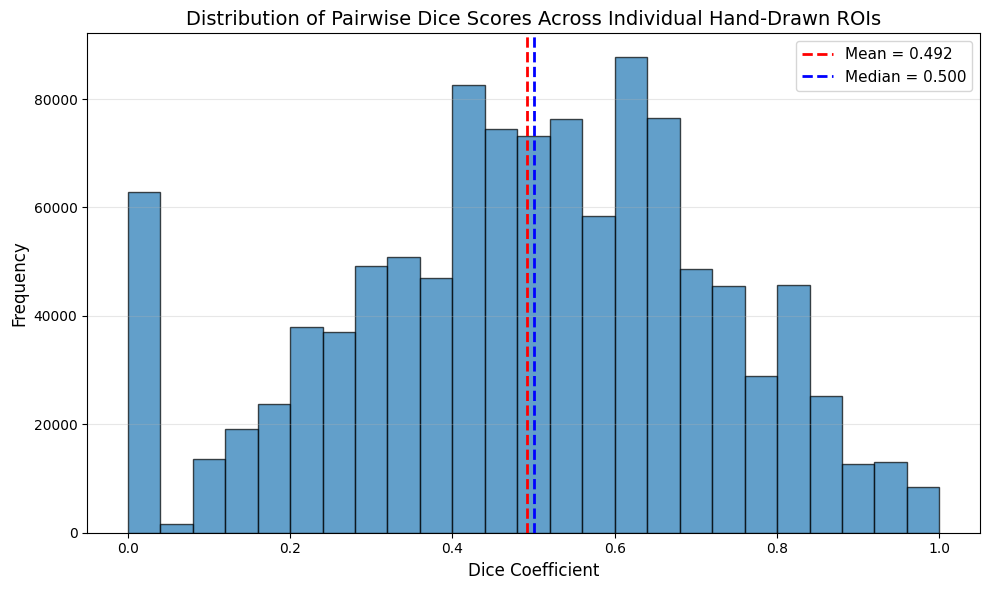

In [7]:
# Create histogram of pairwise Dice scores
results_path = os.path.join(subj_rois_dir, "pairwise_dice_results.pkl.gz")
with gzip.open(results_path, 'rb') as f:
    data = pickle.load(f)

dice_matrix = data['dice_matrix']
roi_names = data['roi_names']
pairwise_values = data['pairwise_dice_values']

plt.figure(figsize=(10, 6))
plt.hist(pairwise_values, bins=25, edgecolor='black', alpha=0.7)
plt.xlabel('Dice Coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Pairwise Dice Scores Across Individual Hand-Drawn ROIs', fontsize=14)
plt.axvline(np.mean(pairwise_values), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {np.mean(pairwise_values):.3f}')
plt.axvline(np.median(pairwise_values), color='blue', linestyle='--', linewidth=2,
            label=f'Median = {np.median(pairwise_values):.3f}')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Ensure all NIfTI files are loaded, binarized, and saved in AFNI-compatible format
avg_subj_roi = os.path.join(subj_rois_dir, "subj_averaged_hbroi.nii.gz")

if os.path.exists(avg_subj_roi):
    print(f"Averaged ROI already exists at {avg_subj_roi}")
else:
    afni_nii_files = []
    for i, roi_file in enumerate(subj_roi_files):
        img = nib.load(roi_file)
        data = img.get_fdata()
        # Binarize: set all nonzero voxels to 1
        bin_data = (data > 0).astype(np.uint8)
        bin_img = nib.Nifti1Image(bin_data, img.affine, img.header)
        temp_fn = os.path.join(subj_rois_dir, f"afni_bin_roi_{i}.nii.gz")
        nib.save(bin_img, temp_fn)
        afni_nii_files.append(temp_fn)

    # Use AFNI 3dMean to average all binarized ROIs
    mean_cmd = f"3dMean -prefix {avg_subj_roi} {' '.join(afni_nii_files)} > /dev/null 2>&1"
    os.system(mean_cmd)

    print(f"Averaged binarized ROI saved to: {avg_subj_roi}")
    # Clean up temporary binarized ROI files
    print("Cleaning up temporary binarized ROI files...")
    for temp_file in afni_nii_files:
        if os.path.exists(temp_file):
            os.remove(temp_file)
            print(f"Deleted: {temp_file}")
    print("Cleanup completed.")

Averaged ROI already exists at ./dset/seed-regions/subj-spec-hbs/subj_averaged_hbroi.nii.gz


In [9]:
# load the atlas based roi
atlas_roi_dir = op.join(rois_dir, "atlas-based-hb")
atlas_roi= glob.glob(op.join(atlas_roi_dir, "*dilated.nii.gz"))

print(atlas_roi)

['./dset/seed-regions/atlas-based-hb/habenula_mni_dilated.nii.gz']


In [10]:

atlas_roi_img = nib.load(atlas_roi[0])  # Take first file from the list
avg_roi_img = nib.load(avg_subj_roi)

atlas_roi_resampled = resample_to_img(atlas_roi_img, avg_roi_img, interpolation='nearest')
print(f"Atlas ROI shape: {atlas_roi_resampled.shape}")


Atlas ROI shape: (97, 115, 97, 1)


/Users/chloehampson/Desktop/habenula-comparison/.venv/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


In [11]:
# Calculate Dice coefficient between subject-averaged ROI and atlas ROI
atlas_vs_subj_dice = dice_coefficient(atlas_roi_resampled, avg_roi_img)

print(f"Dice coefficient between Atlas ROI and Subject-Averaged ROI: {atlas_vs_subj_dice:.4f}")

Dice coefficient between Atlas ROI and Subject-Averaged ROI: 0.6424


In [12]:
# Single iteration: randomly select increasing numbers of subj ROIs,
# average them using AFNI 3dMean (same approach as averaged ROI creation)
np.random.seed(42)

# Create binary ROIs folder
binary_rois_dir = os.path.join(subj_rois_dir, "binary_rois")
os.makedirs(binary_rois_dir, exist_ok=True)

# Create averaged ROIs folder
averaged_rois_dir = os.path.join(subj_rois_dir, "averaged_rois")
os.makedirs(averaged_rois_dir, exist_ok=True)

# Binarize all ROIs once and save to binary_rois folder
print("Binarizing all subject ROIs...")
binary_roi_files = []
for i, roi_file in enumerate(subj_roi_files):
    img = nib.load(roi_file)
    data = img.get_fdata()
    # Binarize: set all nonzero voxels to 1
    bin_data = (data > 0).astype(np.uint8)
    bin_img = nib.Nifti1Image(bin_data, img.affine, img.header)
    
    # Save with same basename but in binary_rois folder
    basename = os.path.basename(roi_file)
    bin_fn = os.path.join(binary_rois_dir, f"bin_{basename}")
    nib.save(bin_img, bin_fn)
    binary_roi_files.append(bin_fn)
    
    if (i + 1) % 100 == 0:
        print(f"Binarized {i + 1}/{len(subj_roi_files)} ROIs")

print(f"Binarized {len(binary_roi_files)}/{len(subj_roi_files)} ROIs")
print(f"All binarized ROIs saved to: {binary_rois_dir}")



Binarizing all subject ROIs...
Binarized 100/1482 ROIs
Binarized 200/1482 ROIs
Binarized 300/1482 ROIs
Binarized 400/1482 ROIs
Binarized 500/1482 ROIs
Binarized 600/1482 ROIs
Binarized 700/1482 ROIs
Binarized 800/1482 ROIs
Binarized 900/1482 ROIs
Binarized 1000/1482 ROIs
Binarized 1100/1482 ROIs
Binarized 1200/1482 ROIs
Binarized 1300/1482 ROIs
Binarized 1400/1482 ROIs
Binarized 1482/1482 ROIs
All binarized ROIs saved to: ./dset/seed-regions/subj-spec-hbs/binary_rois


In [13]:
# Load reference image to get shape and affine
ref_img = nib.load(subj_roi_files[0])

# Load and resample atlas ROI to match subject space
atlas_img = nib.load(atlas_roi[0])
print(atlas_roi[0])
atlas_resampled = resample_to_img(atlas_img, ref_img, interpolation='nearest')


./dset/seed-regions/atlas-based-hb/habenula_mni_dilated.nii.gz


/Users/chloehampson/Desktop/habenula-comparison/.venv/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


In [14]:
# # Define sample sizes: 10, 20, 30, ... up to total number of subjects
# n_total = len(binary_roi_files)
# print(f"Total number of binary ROIs: {n_total}")

# sample_sizes = list(range(10, n_total + 1, 10))
# if sample_sizes[-1] != n_total:
#     sample_sizes.append(n_total)

# print(f"Sample sizes to test: {sample_sizes}")
# dice_by_n = []
# shuffled_files = np.random.permutation(binary_roi_files).tolist()

# print("\nCalculating convergence...")
# for n in sample_sizes:
#     selected_files = shuffled_files[:n]
    
#     # Create a temporary file list to avoid command line length issues
#     file_list_path = os.path.join(averaged_rois_dir, f"temp_filelist_n{n}.txt")
#     with open(file_list_path, 'w') as f:
#         for file_path in selected_files:
#             f.write(f"{file_path}\n")
    
#     # Use AFNI 3dMean with @ syntax to read file list
#     avg_roi_fn = os.path.join(averaged_rois_dir, f"convergence_avg_n{n}.nii.gz")
#     mean_cmd = f"3dMean -prefix {avg_roi_fn} `cat {file_list_path}`"
#     result = os.system(mean_cmd)
    
#     # Clean up temp file list
#     os.remove(file_list_path)
    
#     if result != 0:
#         print(f"WARNING: 3dMean failed for n={n}")
#         continue
    
#     # Load averaged ROI and calculate Dice against atlas
#     avg_img = nib.load(avg_roi_fn)
#     dice_score = dice_coefficient(avg_img, atlas_resampled)
#     dice_by_n.append(dice_score)
    
#     if n % 100 == 0 or n == sample_sizes[-1]:
#         print(f"n={n}: Dice = {dice_score:.4f}")

# print(f"\nAll averaged ROIs saved to: {averaged_rois_dir}")

In [15]:
# # Plot convergence curve
# plt.figure(figsize=(12, 6))
# plt.plot(sample_sizes, dice_by_n, 'o-', color='teal', markersize=3, linewidth=1.5)
# plt.xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
# plt.ylabel('Dice Coefficient vs Atlas ROI', fontsize=12)
# plt.title('Convergence: Random Subject-Averaged ROI vs Atlas ROI (Single Iteration)', fontsize=14)
# plt.axhline(atlas_vs_subj_dice, color='red', linestyle='--', linewidth=1.5,
#             label=f'All subjects averaged = {atlas_vs_subj_dice:.4f}')
# plt.legend(fontsize=11)
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

Total number of binary ROIs: 1482
Sample sizes to test: [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510, 530, 550, 570, 590, 610, 630, 650, 670, 690, 710, 730, 750, 770, 790, 810, 830, 850, 870, 890, 910, 930, 950, 970, 990, 1010, 1030, 1050, 1070, 1090, 1110, 1130, 1150, 1170, 1190, 1210, 1230, 1250, 1270, 1290, 1310, 1330, 1350, 1370, 1390, 1410, 1430, 1450, 1470, 1482]

RUNNING 2 ITERATIONS PER SAMPLE SIZE

n=10: Running 2 iterations...
  n=10: 0.3923 ± 0.0846

n=30: Running 2 iterations...
  n=30: 0.6262 ± 0.0488

n=50: Running 2 iterations...
  n=50: 0.7061 ± 0.0223

n=70: Running 2 iterations...
  n=70: 0.6778 ± 0.0196

n=90: Running 2 iterations...
  n=90: 0.7940 ± 0.0082

n=110: Running 2 iterations...
  n=110: 0.7734 ± 0.0405

n=130: Running 2 iterations...
  n=130: 0.8115 ± 0.0289

n=150: Running 2 iterations...
  n=150: 0.8184 ± 0.0107

n=170: Running 2 iterations...
  n=170: 0.8012 ± 0.0196

n=190:

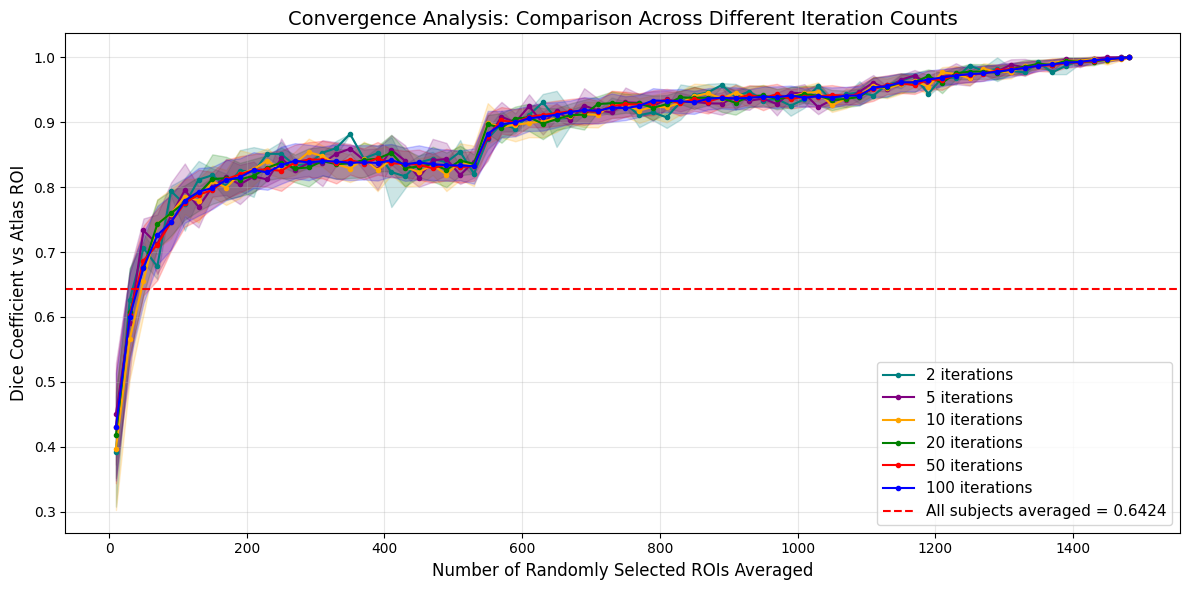

In [ ]:
# Define sample sizes: 10, 20, 30, ... up to total number of subjects
n_total = len(binary_roi_files)
print(f"Total number of binary ROIs: {n_total}")

sample_sizes = list(range(10, n_total + 1, 20))
if sample_sizes[-1] != n_total:
    sample_sizes.append(n_total)

print(f"Sample sizes to test: {sample_sizes}")

# Number of iterations per sample size - can run multiple
ITERATION_COUNTS = [2, 5, 10, 20, 50, 100]  # Add or remove iteration counts as needed

# Store all results for plotting
all_iteration_results = {}

for N_ITERATIONS in ITERATION_COUNTS:
    # Check if results already exist
    results_file = os.path.join(subj_rois_dir, f"avgroi_{N_ITERATIONS}iters_results.pkl.gz")
    
    if os.path.exists(results_file):
        with gzip.open(results_file, 'rb') as f:
            all_iteration_results[N_ITERATIONS] = pickle.load(f)
    else:
        print(f"\n{'='*70}")
        print(f"RUNNING {N_ITERATIONS} ITERATIONS PER SAMPLE SIZE")
        print(f"{'='*70}")
        
        mean_dice_by_n = []
        std_dice_by_n = []
        
        for n in sample_sizes:
            print(f"\nn={n}: Running {N_ITERATIONS} iterations...")
            
            # Store Dice scores for this sample size across iterations
            dice_scores_for_n = []
            
            for iteration in range(N_ITERATIONS):
                # Different random shuffle for each iteration
                shuffled_files = np.random.permutation(binary_roi_files).tolist()
                selected_files = shuffled_files[:n]
                
                # Create a temporary file list to avoid command line length issues
                file_list_path = os.path.join(averaged_rois_dir, f"temp_avgroi_filelist_n{n}_iter{iteration}.txt")
                with open(file_list_path, 'w') as f:
                    for file_path in selected_files:
                        f.write(f"{file_path}\n")
                
                # Use AFNI 3dMean with @ syntax to read file list
                avg_roi_fn = os.path.join(averaged_rois_dir, f"avgroi_n{n}_iter{iteration}.nii.gz")
                mean_cmd = f"3dMean -prefix {avg_roi_fn} `cat {file_list_path}` > /dev/null 2>&1"
                result = os.system(mean_cmd)
                
                # Clean up temp file list
                os.remove(file_list_path)
                
                if result != 0:
                    print(f"WARNING: 3dMean failed for n={n}, iteration {iteration}")
                    dice_scores_for_n.append(np.nan)
                    continue
                
                # Load averaged ROI and calculate Dice against atlas
                avg_img = nib.load(avg_roi_fn)
                dice_score = dice_coefficient(avg_img, avg_roi_img)
                dice_scores_for_n.append(dice_score)
                
                # Optional: delete the averaged ROI to save space
                os.remove(avg_roi_fn)
            
            # Calculate mean and SD for this sample size
            mean_dice = np.nanmean(dice_scores_for_n)
            std_dice = np.nanstd(dice_scores_for_n)
            
            mean_dice_by_n.append(mean_dice)
            std_dice_by_n.append(std_dice)
            
            print(f"  n={n}: {mean_dice:.4f} ± {std_dice:.4f}")
        
        # Store results
        all_iteration_results[N_ITERATIONS] = {
            'mean': np.array(mean_dice_by_n),
            'std': np.array(std_dice_by_n),
            'sample_sizes': sample_sizes,
            'n_iterations': N_ITERATIONS
        }
        
        # Save results
        print(f"\nSaving results to {results_file}...")
        with gzip.open(results_file, 'wb') as f:
            pickle.dump(all_iteration_results[N_ITERATIONS], f)
        print(f"Results saved successfully!")
        print(f"\nMean Dice scores across {N_ITERATIONS} iterations per sample size:")
        for i, n in enumerate(sample_sizes):
            if n % 100 == 0 or n == sample_sizes[-1]:
                print(f"n={n}: {all_iteration_results[N_ITERATIONS]['mean'][i]:.4f} ± {all_iteration_results[N_ITERATIONS]['std'][i]:.4f}")

# Plot convergence curves for all iteration counts
plt.figure(figsize=(12, 6))
colors = ['teal', 'purple', 'orange', 'green', 'red', 'blue']

for idx, N_ITERATIONS in enumerate(ITERATION_COUNTS):
    if N_ITERATIONS in all_iteration_results:
        all_results = all_iteration_results[N_ITERATIONS]
        color = colors[idx % len(colors)]
        result_sample_sizes = all_results['sample_sizes']
        
        plt.plot(result_sample_sizes, all_results['mean'], 'o-', color=color, 
                markersize=3, linewidth=1.5, label=f'{N_ITERATIONS} iterations')
        plt.fill_between(result_sample_sizes, 
                         all_results['mean'] - all_results['std'], 
                         all_results['mean'] + all_results['std'], 
                         color=color, alpha=0.2)

plt.axhline(atlas_vs_subj_dice, color='red', linestyle='--', linewidth=1.5,
            label=f'All subjects averaged = {atlas_vs_subj_dice:.4f}')
plt.xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
plt.ylabel('Dice Coefficient vs Atlas ROI', fontsize=12)
plt.title(f'Convergence Analysis: Comparison Across Different Iteration Counts', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# # Define sample sizes: 10, 20, 30, ... up to total number of subjects
# n_total = len(binary_roi_files)
# print(f"Total number of binary ROIs: {n_total}")

# sample_sizes = list(range(10, n_total + 1, 20))
# if sample_sizes[-1] != n_total:
#     sample_sizes.append(n_total)

# print(f"Sample sizes to test: {sample_sizes}")

# # Number of iterations per sample size
# N_ITERATIONS = 20

# # Check if results already exist
# results_file = os.path.join(subj_rois_dir, f"convergence_{N_ITERATIONS}iters_results.pkl.gz")

# if os.path.exists(results_file):
#     print(f"\n{'='*70}")
#     print(f"LOADING EXISTING RESULTS FOR {N_ITERATIONS} ITERATIONS")
#     print(f"{'='*70}")
#     with gzip.open(results_file, 'rb') as f:
#         all_results = pickle.load(f)
#     print(f"Loaded results from {results_file}")
# else:
#     print(f"\n{'='*70}")
#     print(f"RUNNING {N_ITERATIONS} ITERATIONS PER SAMPLE SIZE")
#     print(f"{'='*70}")
    
#     mean_dice_by_n = []
#     std_dice_by_n = []
    
#     for n in sample_sizes:
#         print(f"\nn={n}: Running {N_ITERATIONS} iterations...")
        
#         # Store Dice scores for this sample size across iterations
#         dice_scores_for_n = []
        
#         for iteration in range(N_ITERATIONS):
#             # Different random shuffle for each iteration
#             shuffled_files = np.random.permutation(binary_roi_files).tolist()
#             selected_files = shuffled_files[:n]
            
#             # Create a temporary file list to avoid command line length issues
#             file_list_path = os.path.join(averaged_rois_dir, f"temp_filelist_n{n}_iter{iteration}.txt")
#             with open(file_list_path, 'w') as f:
#                 for file_path in selected_files:
#                     f.write(f"{file_path}\n")
            
#             # Use AFNI 3dMean with @ syntax to read file list
#             avg_roi_fn = os.path.join(averaged_rois_dir, f"convergence_n{n}_iter{iteration}.nii.gz")
#             mean_cmd = f"3dMean -prefix {avg_roi_fn} `cat {file_list_path}` > /dev/null 2>&1"
#             result = os.system(mean_cmd)
            
#             # Clean up temp file list
#             os.remove(file_list_path)
            
#             if result != 0:
#                 print(f"WARNING: 3dMean failed for n={n}, iteration {iteration}")
#                 dice_scores_for_n.append(np.nan)
#                 continue
            
#             # Load averaged ROI and calculate Dice against atlas
#             avg_img = nib.load(avg_roi_fn)
#             dice_score = dice_coefficient(avg_img, atlas_resampled)
#             dice_scores_for_n.append(dice_score)
            
#             # Optional: delete the averaged ROI to save space
#             os.remove(avg_roi_fn)
        
#         # Calculate mean and SD for this sample size
#         mean_dice = np.nanmean(dice_scores_for_n)
#         std_dice = np.nanstd(dice_scores_for_n)
        
#         mean_dice_by_n.append(mean_dice)
#         std_dice_by_n.append(std_dice)
        
#         print(f"  n={n}: {mean_dice:.4f} ± {std_dice:.4f}")
    
#     # Store results
#     all_results = {
#         'mean': np.array(mean_dice_by_n),
#         'std': np.array(std_dice_by_n),
#         'sample_sizes': sample_sizes,
#         'n_iterations': N_ITERATIONS
#     }
    
#     # Save results
#     print(f"\nSaving results to {results_file}...")
#     with gzip.open(results_file, 'wb') as f:
#         pickle.dump(all_results, f)
#     print(f"Results saved successfully!")

# print(f"\nMean Dice scores across {N_ITERATIONS} iterations per sample size:")
# for i, n in enumerate(sample_sizes):
#     if n % 100 == 0 or n == sample_sizes[-1]:
#         print(f"n={n}: {all_results['mean'][i]:.4f} ± {all_results['std'][i]:.4f}")

# print(f"\nAll averaged ROIs saved to: {averaged_rois_dir}")

# # Plot convergence curve
# plt.figure(figsize=(12, 6))
# plt.plot(sample_sizes, all_results['mean'], 'o-', color='teal', markersize=3, linewidth=1.5, label='Mean Dice')
# plt.fill_between(sample_sizes, 
#                  all_results['mean'] - all_results['std'], 
#                  all_results['mean'] + all_results['std'], 
#                  color='teal', alpha=0.2, label='±1 SD')
# plt.xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
# plt.ylabel('Dice Coefficient vs Atlas ROI', fontsize=12)
# plt.title(f'Convergence Analysis ({N_ITERATIONS} Iterations per Sample Size)', fontsize=14)
# plt.axhline(atlas_vs_subj_dice, color='red', linestyle='--', linewidth=1.5,
#             label=f'All subjects averaged = {atlas_vs_subj_dice:.4f}')
# plt.legend(fontsize=11)
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

In [18]:
# Define sample sizes: 10, 20, 30, ... up to total number of subjects
'''n_total = len(binary_roi_files)
print(f"Total number of binary ROIs: {n_total}")

sample_sizes = list(range(10, n_total + 1, 20))
if sample_sizes[-1] != n_total:
    sample_sizes.append(n_total)

print(f"Sample sizes to test: {sample_sizes}")

# Different iteration sets to test
ITERATION_SETS = [1000]

# Store results for each iteration set
all_results = {}

for N_ITERATIONS in ITERATION_SETS:
    # Check if results already exist for this iteration count
    results_file = os.path.join(subj_rois_dir, f"convergence_{N_ITERATIONS}iters_results.pkl.gz")
    
    if os.path.exists(results_file):
        print(f"\n{'='*70}")
        print(f"LOADING EXISTING RESULTS FOR {N_ITERATIONS} ITERATIONS")
        print(f"{'='*70}")
        with gzip.open(results_file, 'rb') as f:
            all_results[N_ITERATIONS] = pickle.load(f)
        print(f"Loaded results from {results_file}")
        continue
    
    print(f"\n{'='*70}")
    print(f"RUNNING {N_ITERATIONS} ITERATIONS")
    print(f"{'='*70}")
    
    # Store Dice scores for each iteration
    dice_by_iteration = []
    
    for iteration in range(N_ITERATIONS):
        print(f"\nIteration {iteration + 1}/{N_ITERATIONS}")
        
        dice_by_n = []
        # Different random shuffle for each iteration
        shuffled_files = np.random.permutation(binary_roi_files).tolist()
        
        for n in sample_sizes:
            selected_files = shuffled_files[:n]
            
            # Create a temporary file list to avoid command line length issues
            file_list_path = os.path.join(averaged_rois_dir, f"temp_filelist_iter{iteration}_n{n}.txt")
            with open(file_list_path, 'w') as f:
                for file_path in selected_files:
                    f.write(f"{file_path}\n")
            
            # Use AFNI 3dMean with @ syntax to read file list
            avg_roi_fn = os.path.join(averaged_rois_dir, f"convergence_{N_ITERATIONS}iters_iter{iteration}_n{n}.nii.gz")
            mean_cmd = f"3dMean -prefix {avg_roi_fn} `cat {file_list_path}`"
            result = os.system(mean_cmd)
            
            # Clean up temp file list
            os.remove(file_list_path)
            
            if result != 0:
                print(f"WARNING: 3dMean failed for iteration {iteration}, n={n}")
                dice_by_n.append(np.nan)
                continue
            
            # Load averaged ROI and calculate Dice against atlas
            avg_img = nib.load(avg_roi_fn)
            dice_score = dice_coefficient(avg_img, atlas_resampled)
            dice_by_n.append(dice_score)
        
        dice_by_iteration.append(dice_by_n)
        
        # Progress update
        if (iteration + 1) % 5 == 0 or (iteration + 1) == N_ITERATIONS:
            print(f"Completed {iteration + 1}/{N_ITERATIONS} iterations")
    
    # Calculate mean and SD across iterations for each sample size
    dice_by_iteration = np.array(dice_by_iteration)  # Shape: (N_ITERATIONS, len(sample_sizes))
    mean_dice = np.nanmean(dice_by_iteration, axis=0)
    std_dice = np.nanstd(dice_by_iteration, axis=0)
    
    # Store results
    all_results[N_ITERATIONS] = {
        'mean': mean_dice,
        'std': std_dice,
        'all_dice': dice_by_iteration,
        'sample_sizes': sample_sizes
    }
    
    # Save results for this iteration count
    print(f"\nSaving results to {results_file}...")
    with gzip.open(results_file, 'wb') as f:
        pickle.dump(all_results[N_ITERATIONS], f)
    print(f"Results saved successfully!")
    
    print(f"\nMean Dice scores across {N_ITERATIONS} iterations:")
    for i, n in enumerate(sample_sizes):
        if n % 200 == 0 or n == sample_sizes[-1]:
            print(f"n={n}: {mean_dice[i]:.4f} ± {std_dice[i]:.4f}")

print(f"\nAll averaged ROIs saved to: {averaged_rois_dir}")

'''

'n_total = len(binary_roi_files)\nprint(f"Total number of binary ROIs: {n_total}")\n\nsample_sizes = list(range(10, n_total + 1, 20))\nif sample_sizes[-1] != n_total:\n    sample_sizes.append(n_total)\n\nprint(f"Sample sizes to test: {sample_sizes}")\n\n# Different iteration sets to test\nITERATION_SETS = [1000]\n\n# Store results for each iteration set\nall_results = {}\n\nfor N_ITERATIONS in ITERATION_SETS:\n    # Check if results already exist for this iteration count\n    results_file = os.path.join(subj_rois_dir, f"convergence_{N_ITERATIONS}iters_results.pkl.gz")\n    \n    if os.path.exists(results_file):\n        print(f"\n{\'=\'*70}")\n        print(f"LOADING EXISTING RESULTS FOR {N_ITERATIONS} ITERATIONS")\n        print(f"{\'=\'*70}")\n        with gzip.open(results_file, \'rb\') as f:\n            all_results[N_ITERATIONS] = pickle.load(f)\n        print(f"Loaded results from {results_file}")\n        continue\n    \n    print(f"\n{\'=\'*70}")\n    print(f"RUNNING {N_ITERATI

In [19]:
# Load results from pickle files and plot
'''ITERATION_SETS = [1000]
all_results = {}

print("Loading results from pickle files...")
for N_ITERATIONS in ITERATION_SETS:
    results_file = os.path.join(subj_rois_dir, f"convergence_{N_ITERATIONS}iters_results.pkl.gz")
    if os.path.exists(results_file):
        with gzip.open(results_file, 'rb') as f:
            all_results[N_ITERATIONS] = pickle.load(f)
        print(f"Loaded results for {N_ITERATIONS} iterations")
    else:
        print(f"WARNING: Results file not found for {N_ITERATIONS} iterations: {results_file}")

# Get sample_sizes from the first available result
sample_sizes = None
for N_ITERATIONS in ITERATION_SETS:
    if N_ITERATIONS in all_results:
        sample_sizes = all_results[N_ITERATIONS]['sample_sizes']
        break

if sample_sizes is None:
    print("ERROR: No results found to plot!")
else:
    # Plot all iteration sets on one figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, N_ITERATIONS in enumerate(ITERATION_SETS):
        ax = axes[idx]
        if N_ITERATIONS in all_results:
            mean_dice = all_results[N_ITERATIONS]['mean']
            std_dice = all_results[N_ITERATIONS]['std']
            
            ax.plot(sample_sizes, mean_dice, 'o-', color='teal', markersize=3, linewidth=1.5, label='Mean Dice')
            ax.fill_between(sample_sizes, mean_dice - std_dice, mean_dice + std_dice, 
                             color='teal', alpha=0.2, label='±1 SD')
            ax.axhline(atlas_vs_subj_dice, color='red', linestyle='--', linewidth=1.5,
                        label=f'All subjects = {atlas_vs_subj_dice:.4f}')
            ax.set_xlabel('Number of Randomly Selected ROIs Averaged', fontsize=11)
            ax.set_ylabel('Dice Coefficient vs Atlas ROI', fontsize=11)
            ax.set_title(f'{N_ITERATIONS} Iterations', fontsize=13, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'No data for {N_ITERATIONS} iterations', 
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{N_ITERATIONS} Iterations (No Data)', fontsize=13)

    plt.suptitle('Convergence Analysis: Effect of Number of Iterations', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Summary comparison plot: SD at different sample sizes across iteration counts
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['blue', 'green', 'orange', 'red']

    for idx, N_ITERATIONS in enumerate(ITERATION_SETS):
        if N_ITERATIONS in all_results:
            std_dice = all_results[N_ITERATIONS]['std']
            ax.plot(sample_sizes, std_dice, 'o-', color=colors[idx], markersize=3, 
                    linewidth=1.5, label=f'{N_ITERATIONS} iterations')

    ax.set_xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
    ax.set_ylabel('Standard Deviation of Dice Coefficient', fontsize=12)
    ax.set_title('Stability Across Iterations: How SD Changes with Sample Size', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
'''

'ITERATION_SETS = [1000]\nall_results = {}\n\nprint("Loading results from pickle files...")\nfor N_ITERATIONS in ITERATION_SETS:\n    results_file = os.path.join(subj_rois_dir, f"convergence_{N_ITERATIONS}iters_results.pkl.gz")\n    if os.path.exists(results_file):\n        with gzip.open(results_file, \'rb\') as f:\n            all_results[N_ITERATIONS] = pickle.load(f)\n        print(f"Loaded results for {N_ITERATIONS} iterations")\n    else:\n        print(f"WARNING: Results file not found for {N_ITERATIONS} iterations: {results_file}")\n\n# Get sample_sizes from the first available result\nsample_sizes = None\nfor N_ITERATIONS in ITERATION_SETS:\n    if N_ITERATIONS in all_results:\n        sample_sizes = all_results[N_ITERATIONS][\'sample_sizes\']\n        break\n\nif sample_sizes is None:\n    print("ERROR: No results found to plot!")\nelse:\n    # Plot all iteration sets on one figure\n    fig, axes = plt.subplots(2, 2, figsize=(16, 12))\n    axes = axes.flatten()\n\n    for idx

In [20]:
# Pairwise Dice analysis with iterations
# Test sample sizes from 2 to 100 ROIs, with 10 iterations each

'''print("\n" + "="*70)
print("PAIRWISE DICE ANALYSIS: 2-100 ROIs with 1000 Iterations Each")
print("="*70)

# Define parameters
PAIRWISE_SAMPLE_SIZES = list(range(2, 10))  # 2, 3, 4, ..., 100
PAIRWISE_ITERATIONS = 1000

# Check if results already exist
pairwise_results_file = os.path.join(subj_rois_dir, "pairwise_convergence_results.pkl.gz")

if os.path.exists(pairwise_results_file):
    print(f"\nLOADING EXISTING PAIRWISE RESULTS")
    with gzip.open(pairwise_results_file, 'rb') as f:
        pairwise_results = pickle.load(f)
    print(f"Loaded results from {pairwise_results_file}")
else:
    print(f"\nRunning pairwise analysis for sample sizes 2-100 with {PAIRWISE_ITERATIONS} iterations each...")
    
    mean_pairwise_by_n = []
    std_pairwise_by_n = []
    
    for n in PAIRWISE_SAMPLE_SIZES:
        print(f"\nn={n}: Running {PAIRWISE_ITERATIONS} iterations...")
        
        # Store pairwise Dice for this sample size across iterations
        iteration_dice_values = []
        
        for iteration in range(PAIRWISE_ITERATIONS):
            # Randomly select n ROIs for this iteration
            selected_files = np.random.choice(binary_roi_files, size=n, replace=False)
            
            # Calculate all pairwise Dice among these n ROIs
            pairwise_scores = []
            for i in range(len(selected_files)):
                roi1 = nib.load(selected_files[i])
                for j in range(i+1, len(selected_files)):
                    roi2 = nib.load(selected_files[j])
                    dice = dice_coefficient(roi1, roi2)
                    pairwise_scores.append(dice)
            
            # Take mean of all pairwise comparisons for this iteration
            mean_dice_this_iteration = np.mean(pairwise_scores)
            iteration_dice_values.append(mean_dice_this_iteration)
        
        # Average across the 10 iterations for this sample size
        mean_for_n = np.mean(iteration_dice_values)
        std_for_n = np.std(iteration_dice_values)
        
        mean_pairwise_by_n.append(mean_for_n)
        std_pairwise_by_n.append(std_for_n)
        
        print(f"  n={n}: {mean_for_n:.4f} ± {std_for_n:.4f}")
    
    # Store results
    pairwise_results = {
        'mean': np.array(mean_pairwise_by_n),
        'std': np.array(std_pairwise_by_n),
        'sample_sizes': PAIRWISE_SAMPLE_SIZES,
        'n_iterations': PAIRWISE_ITERATIONS
    }
    
    # Save results
    print(f"\nSaving pairwise results to {pairwise_results_file}...")
    with gzip.open(pairwise_results_file, 'wb') as f:
        pickle.dump(pairwise_results, f)
    print("Pairwise results saved successfully!")

# Print summary
print(f"\nPairwise Dice Summary ({PAIRWISE_ITERATIONS} iterations per sample size):")
for i, n in enumerate(PAIRWISE_SAMPLE_SIZES):
    if n % 20 == 0 or n == 2 or n == PAIRWISE_SAMPLE_SIZES[-1]:
        print(f"n={n}: {pairwise_results['mean'][i]:.4f} ± {pairwise_results['std'][i]:.4f}")

# Plot pairwise convergence
plt.figure(figsize=(12, 6))
plt.plot(PAIRWISE_SAMPLE_SIZES, pairwise_results['mean'], 'o-', color='purple', 
         markersize=3, linewidth=1.5, label='Mean Pairwise Dice')
plt.fill_between(PAIRWISE_SAMPLE_SIZES, 
                 pairwise_results['mean'] - pairwise_results['std'], 
                 pairwise_results['mean'] + pairwise_results['std'], 
                 color='purple', alpha=0.2, label='±1 SD')
plt.xlabel('Number of ROIs in Random Sample', fontsize=12)
plt.ylabel('Mean Pairwise Dice Coefficient', fontsize=12)
plt.title(f'Pairwise Dice Among Random ROI Subsets ({PAIRWISE_ITERATIONS} Iterations per N)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()'''

'print("\n" + "="*70)\nprint("PAIRWISE DICE ANALYSIS: 2-100 ROIs with 1000 Iterations Each")\nprint("="*70)\n\n# Define parameters\nPAIRWISE_SAMPLE_SIZES = list(range(2, 10))  # 2, 3, 4, ..., 100\nPAIRWISE_ITERATIONS = 1000\n\n# Check if results already exist\npairwise_results_file = os.path.join(subj_rois_dir, "pairwise_convergence_results.pkl.gz")\n\nif os.path.exists(pairwise_results_file):\n    print(f"\nLOADING EXISTING PAIRWISE RESULTS")\n    with gzip.open(pairwise_results_file, \'rb\') as f:\n        pairwise_results = pickle.load(f)\n    print(f"Loaded results from {pairwise_results_file}")\nelse:\n    print(f"\nRunning pairwise analysis for sample sizes 2-100 with {PAIRWISE_ITERATIONS} iterations each...")\n    \n    mean_pairwise_by_n = []\n    std_pairwise_by_n = []\n    \n    for n in PAIRWISE_SAMPLE_SIZES:\n        print(f"\nn={n}: Running {PAIRWISE_ITERATIONS} iterations...")\n        \n        # Store pairwise Dice for this sample size across iterations\n        iterati

In [21]:
# # 10 iterations: randomly select increasing numbers of subj ROIs,
# # average them, compute Dice vs atlas, then average across iterations
# n_iterations = 10
# n_total = len(subj_roi_files)

# sample_sizes = list(range(10, n_total + 1, 10))
# if sample_sizes[-1] != n_total:
#     sample_sizes.append(n_total)

# # Store Dice scores for each iteration
# all_dice_scores = np.zeros((n_iterations, len(sample_sizes)))

# for iteration in range(n_iterations):
#     print(f"Iteration {iteration + 1}/{n_iterations}...")
#     shuffled_files = np.random.permutation(subj_roi_files).tolist()
    
#     for s_idx, n in enumerate(sample_sizes):
#         selected_files = shuffled_files[:n]
        
#         # Binarize and average selected ROIs using numpy
#         roi_stack = []
#         for roi_file in selected_files:
#             img = nib.load(roi_file)
#             data = img.get_fdata()
#             bin_data = (data > 0).astype(np.float64)
#             roi_stack.append(bin_data)
        
#         # Average across subjects
#         avg_roi = np.mean(roi_stack, axis=0)
        
#         # Create averaged image
#         avg_img = nib.Nifti1Image(avg_roi, ref_img.affine, ref_img.header)
        
#         # Calculate Dice against atlas
#         dice_score = dice_coefficient(avg_img, atlas_resampled)
#         all_dice_scores[iteration, s_idx] = dice_score

# # Calculate mean and std across iterations
# mean_dice = np.mean(all_dice_scores, axis=0)
# std_dice = np.std(all_dice_scores, axis=0)

# print(f"\nResults averaged over {n_iterations} iterations:")
# for s_idx, n in enumerate(sample_sizes):
#     if n % 100 == 0 or n == sample_sizes[-1] or n == 10:
#         print(f"n={n}: Mean Dice = {mean_dice[s_idx]:.4f} ± {std_dice[s_idx]:.4f}")

# # Plot convergence curve with error bands
# plt.figure(figsize=(12, 6))
# plt.plot(sample_sizes, mean_dice, 'o-', color='teal', markersize=3, linewidth=1.5,
#          label='Mean Dice (10 iterations)')
# plt.fill_between(sample_sizes, mean_dice - std_dice, mean_dice + std_dice,
#                  alpha=0.2, color='teal', label='± 1 SD')
# plt.axhline(atlas_vs_subj_dice, color='red', linestyle='--', linewidth=1.5,
#             label=f'All subjects averaged = {atlas_vs_subj_dice:.4f}')
# plt.xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
# plt.ylabel('Dice Coefficient vs Atlas ROI', fontsize=12)
# plt.title(f'Convergence: Random Subject-Averaged ROI vs Atlas ROI ({n_iterations} Iterations)', fontsize=14)
# plt.legend(fontsize=11)
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()